In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer
import tensorflow_probability as tfp

**PREPARE THE DATASET**

In [ ]:
dataset, dataset_info = tfds.load(
    'malaria',
    with_info = True,
    as_supervised = True,
    shuffle_files = True,
    split = ['train']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset

In [ ]:
len(dataset[0])

In [ ]:
def splits(dataset, TRAIN, VAL, TEST):
    # dataset = tf.data.Dataset.range(40)
    dataset_size = len(dataset)
    # print(list(dataset.as_numpy_iterator()))

    train_dataset = dataset.take(int(TRAIN * dataset_size))
    # print(list(train_dataset.as_numpy_iterator()))

    val_dataset = dataset.skip(int(TRAIN * dataset_size)).take(int(VAL * dataset_size))
    # print(list(val_dataset.as_numpy_iterator()))

    test_dataset = dataset.skip(int((TRAIN + VAL) * dataset_size)).take(int(TEST * dataset_size))
    # print(list(test_dataset.as_numpy_iterator()))
    return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.9
VAL = 0.05
TEST = 0.05

# dataset = tf.data.Dataset.range(40)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL, TEST)
print(train_dataset.take(16))
# print(list(val_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

In [ ]:
dataset_info

**DATA VISUALIZATION**

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

**DATA PREPROCESSING**

In [ ]:
def resizing(image, label, IMG_SIZE = 224):
    resized_image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    resized_image = tf.cast(resized_image, tf.float32)
    normalized_data = resized_image/255.0
    return normalized_data, label

DATA AUGMENTATION

In [ ]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [ ]:
original_image = next(iter(train_dataset))[0]
augmented = tf.image.random_saturation(original_image, lower=0.2, upper=0.8)
print(original_image.shape)
print(augmented.shape)
visualize(original_image, augmented)

In [ ]:
# tf.image augment
@tf.function
def augment(image, label):
    image, label = resizing(image, label)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

Build a custom layer

In [ ]:
# create a custome layer class that can rotate images 90 degrees
class RotNinety(Layer):
    def __init__(self):
        super().__init__()

    @tf.function
    def call(self, image):
        return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling
IMG_SIZE = 224

# 2 layers for resizing, and augmenting the dataset
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE, 3),
    Rescaling(1./255),])

augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode="horizontal",),
    RotNinety(),
])

@tf.function
def augment_layer(image, label):
    # image, label = resizing(image, label)
    return augment_layers(resize_rescale_layers(image), training=True), label

In [ ]:
for image, label in train_dataset.take(1):
    print(image.shape, label)

In [ ]:
train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

In [ ]:
# print(list(train_dataset.take(1).as_numpy_iterator()))

In [ ]:
BATCH_SIZE = 32
train_dataset = (train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(augment_layer).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

In [ ]:
val_dataset = (
    val_dataset
    # .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(resizing)
    .batch(BATCH_SIZE))
    # .prefetch(tf.data.AUTOTUNE))

# test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

24802 1377 1377


In [ ]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**MIXUP DATA AUGMENTATION**

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).map(resizing)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).map(resizing)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)

In [ ]:
mixed_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [ ]:
import tensorflow_probability as tfp
# lamda=tfp.distributions.Beta(
#     concentration1=0.2 ,
#     concentration0=0.2,
# )
# print(lamda.sample(1)[0].numpy())

# image = lamda*image_1 + (1-lamda)*image_2
# label = lamda*label_1 + (1-lamda)*label_2

def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    lamda=tfp.distributions.Beta(
    concentration1=0.2 ,
    concentration0=0.2,)
    lamda = lamda.sample(1)[0]
    image = lamda*image_1 + (1-lamda)*image_2
    label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)
    return image, label

**CUTMIX DATA AUGMENTATION**

In [ ]:
def box(lamda, IMG_SIZE = 224):
  """
  This function is for dealing with exception in cutting and cropping the image
  
  """

  r_x = tf.cast(tfp.distributions.Uniform(0, IMG_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IMG_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IMG_SIZE * tf.math.sqrt(1-lamda), dtype=tf.int32)
  r_h = tf.cast(IMG_SIZE * tf.math.sqrt(1-lamda), dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w // 2, 0, IMG_SIZE - r_w)
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, IMG_SIZE - r_h)

  r_b_x = tf.clip_by_value(r_x + r_w, 0, IMG_SIZE)
  r_b_y = tf.clip_by_value(r_y + r_h, 0, IMG_SIZE)

  r_w = r_b_x - r_x
  if r_w == 0:
      r_w = 1
  r_h = r_b_y - r_y
  if r_y == 0:
      r_h = 1
  return r_y, r_x, r_h, r_w

In [ ]:
from tensorflow.image import crop_to_bounding_box, pad_to_bounding_box
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    lamda = tfp.distributions.Beta(
        concentration1=0.2,
        concentration0=0.2,
    ).sample(1)[0]
    box_y, box_x, box_h, box_w = box(lamda)
    crop_1 = crop_to_bounding_box(image_1, box_y, box_x, box_h, box_w)
    pad_1 = pad_to_bounding_box(crop_1, box_y, box_x, IMG_SIZE, IMG_SIZE)

    crop_2 = crop_to_bounding_box(image_2, box_y, box_x, box_h, box_w)
    pad_2 = pad_to_bounding_box(crop_2, box_y, box_x, IMG_SIZE, IMG_SIZE)

    image = image_1 - pad_1 + pad_2
    return image, label

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, reshuffle_each_iteration=True).map(resizing)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, reshuffle_each_iteration=True).map(resizing)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)

In [ ]:
BATCHSIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    # .map(mixup)
    .map(cutmix)
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE))

In [ ]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
original_image, label = next(iter(train_dataset))
plt.title(label)
plt.imshow(original_image[0])

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} assertion failed: [width must be <= target - offset]
	 [[{{node pad_to_bounding_box/Assert_2/Assert}}]] [Op:IteratorGetNext] name: 

**MODELING**

In [ ]:
IMG_SIZE = 224
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, BatchNormalization
from tensorflow.keras.models import Model

model = Sequential()
model.add(InputLayer(input_shape=(None, None, 3)))
model.add(resize_rescale_layers)
model.add(augment_layers)
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │       1,866,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,876,761 (7.16 MB)

 Trainable params: 1,876,593 (7.16 MB)

 Non-trainable params: 168 (672.00 B)

In [ ]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**FUNCTIONAL API**

In [ ]:
IMG_SIZE = 224
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, BatchNormalization
from tensorflow.keras.models import Model

feature_extractor_seq_model = Sequential()
feature_extractor_seq_model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
feature_extractor_seq_model.add(BatchNormalization())
feature_extractor_seq_model.add(MaxPooling2D(pool_size=2, strides=2))

feature_extractor_seq_model.add(Conv2D(32, kernel_size=3, activation='relu'))
feature_extractor_seq_model.add(BatchNormalization())
feature_extractor_seq_model.add(MaxPooling2D(pool_size=2, strides=2))

feature_extractor_seq_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,280 (20.62 KB)

 Trainable params: 5,184 (20.25 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
from tensorflow.keras.layers import Input

func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Input_image")
x = Conv2D(16, kernel_size=3, activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPooling2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="Feature_extracter_model")
feature_extractor.summary()

Model: "Feature_extracter_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,280 (20.62 KB)

 Trainable params: 5,184 (20.25 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
from tensorflow.keras.layers import Input
func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Input_image")

x = feature_extractor_seq_model(func_input)

x= Flatten()(x)
x= Dense(20, activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)
x= Dense(1, activation='sigmoid')(x)

func_model = Model(inputs=func_input, outputs=x, name="func_model")
func_model.summary()

Model: "func_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 54, 54, 32)          │           5,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │       1,866,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,871,641 (7.14 MB)

 Trainable params: 1,871,505 (7.14 MB)

 Non-trainable params: 136 (544.00 B)

**MODEL SUBCLASSING**

In [ ]:
from tensorflow.keras import Input, Model
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size,
                            strides=strides, padding=padding, activation=activation)
        self.batch1 = BatchNormalization()
        self.pool1 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

        self.conv2 = Conv2D(filters=2*filters, kernel_size=kernel_size,
                            strides=strides, padding=padding, activation=activation)
        self.batch2 = BatchNormalization()
        self.pool2 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.pool2(x)
        return x


In [ ]:
# from tensorflow.keras.layers import Input
# func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Input_image")

# x = feature_sub_classed(func_input)

# x= Flatten()(x)
# x= Dense(20, activation='relu')(x)
# x= BatchNormalization()(x)
# x= Dropout(0.2)(x)
# x= Dense(1, activation='sigmoid')(x)

# func_model = Model(inputs=func_input, outputs=x, name="func_model")
# func_model.summary()

class Lenet_model(Model):
    def __init__(self):
        super(Lenet_model, self).__init__()
        self.feature_extractor = FeatureExtractor(64, 3, 1, "valid", "relu", 2)
        self.flatten = Flatten()
        self.dense1 = Dense(20, activation='relu')
        self.batch1 = BatchNormalization()
        self.dropout1 = Dropout(0.2)
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.batch1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

# Instantiate and build the model
lenet_sub_classed = Lenet_model()
sample_input = tf.random.normal((1, IMG_SIZE, IMG_SIZE, 3))
_ = lenet_sub_classed(sample_input)
lenet_sub_classed.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))

# Directly summarize the subclassed model
lenet_sub_classed.summary()


Model: "lenet_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │          76,416 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (1, 373248)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 20)                     │       7,464,980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (1, 20)                     │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 20)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 1)                      │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,541,497 (28.77 MB)

 Trainable params: 7,541,073 (28.77 MB)

 Non-trainable params: 424 (1.66 KB)

**CUSTOM LAYERS**

In [ ]:
class Neuralearn(Layer):
    def __init__(self, units, activation):
        super(Neuralearn, self).__init__()
        self.units = units
        self.activation = activation
    def build(self, input_feature_shape):
        self.w = self.add_weight(
            shape=(input_feature_shape[-1],self.units),
            initializer='random_normal',
            trainable=True)
        self.b = self.add_weight(
            shape=(self.units,),
            initializer='random_normal',
            trainable=True)
    def call(self, inputs):
        pre_out = tf.matmul(inputs, self.w) + self.b
        if(self.activation == 'relu'):
            return tf.nn.relu(pre_out)
        elif(self.activation == 'sigmoid'):
            return tf.math.sigmoid(pre_out)
        else:
            return pre_out

In [ ]:
custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=2, strides=2))

custom_model.add(Conv2D(32, kernel_size=3, activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=2, strides=2))

custom_model.add(Flatten())
custom_model.add(Neuralearn(20, activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.2))
custom_model.add(Neuralearn(1, activation='sigmoid'))

custom_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_2 (Neuralearn)            │ (None, 20)                  │       1,866,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_3 (Neuralearn)            │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,876,761 (7.16 MB)

 Trainable params: 1,876,593 (7.16 MB)

 Non-trainable params: 168 (672.00 B)

**CALLBACK FUNCTION**

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
class LossCallBack(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For the epoch {}, the model calculate the value of loss at {}".format(epoch, logs['loss']))
    def on_batch_end(self, batch, logs):
        print("\n For the batch number {}, the model has the loss of {}".format(batch, logs["loss"]))

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import os
if not os.path.isfile('log.csv'):
    os.mknod('log.csv')
csv_logger = CSVLogger('log.csv', separator=",", append=False)

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1,
                            mode='auto', baseline=None, restore_best_weight=False)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    'checkpoint/',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=3,)

**COMPILE AND TRAIN**

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, Precision, Recall, AUC, Accuracy, TrueNegatives, TruePositives
from tensorflow.keras.optimizers import Adam

metrics = [FalseNegatives(name="fn"), FalsePositives(name="fp"), Precision(name="precision"),
           Recall(name="recall"), AUC(name="auc"), BinaryAccuracy(name="accuracy"), TrueNegatives(name="tn"), TruePositives(name="tp")]



In [ ]:
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=metrics)

history = lenet_sub_classed.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[csv_logger, es_callback, lrs, checkpoint_callback])

Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 100s 114ms/step - accuracy: 0.7204 - auc: 0.7909 - fn: 1236.5649 - fp: 1564.6731 - loss: 0.5770 - precision: 0.7125 - recall: 0.7444 - tn: 4650.8394 - tp: 4995.8042 - val_accuracy: 0.8809 - val_auc: 0.9728 - val_fn: 132.0000 - val_fp: 32.0000 - val_loss: 0.3197 - val_precision: 0.9471 - val_recall: 0.8128 - val_tn: 640.0000 - val_tp: 573.0000
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.9328 - auc: 0.9712 - fn: 303.1570 - fp: 523.3372 - loss: 0.1995 - precision: 0.9188 - recall: 0.9505 - tn: 5692.2173 - tp: 5929.1699 - val_accuracy: 0.8816 - val_auc: 0.9738 - val_fn: 137.0000 - val_fp: 26.0000 - val_loss: 0.3046 - val_precision: 0.9562 - val_recall: 0.8057 - val_tn: 646.0000 - val_tp: 568.0000
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 86s 111ms/step - accuracy: 0.9426 - auc: 0.9798 - fn: 264.6860 - fp: 436.3217 - loss: 0.1679 - precision: 0.9314 - recall: 0.9564 - tn: 5779.3564 - tp: 5967.5176 - val_accuracy: 0.9259 - val_au

**VISUALIZING THE CONFUSION MATRIX**

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import seaborn as sns

In [ ]:
labels = []
input = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    input.append(x)

# labels = np.array([i[0] for i in labels])

In [ ]:
# get the labels of all the test dataset
print(labels)
print(np.array(input).shape)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 

In [ ]:
# pass the input into the model for prediction
predictions = lenet_sub_classed.predict(np.array(input))
print(predictions[:, 0])

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[1.8361585e-11 3.4516326e-12 1.5796390e-07 ... 1.5056419e-02 9.9999750e-01
 1.1280630e-04]


[[673  47]
 [ 81 576]]


Text(0.5, 58.7222222222222, 'Predicted label')

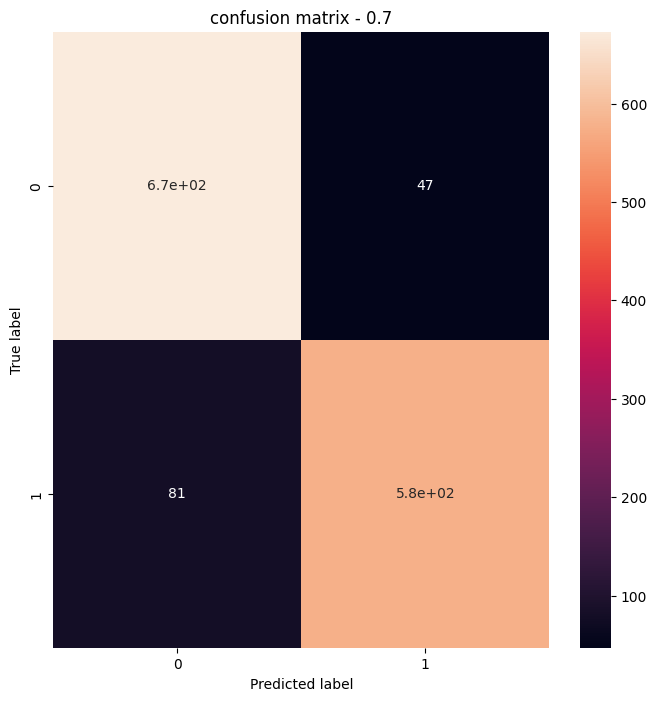

In [ ]:
# plot out the confusion matrix using sklearn
threshold = 0.7

cm = confusion_matrix(labels, predictions[:, 0] > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.title('confusion matrix - {}'.format(threshold))

plt.ylabel('True label')
plt.xlabel('Predicted label')

197 197 197


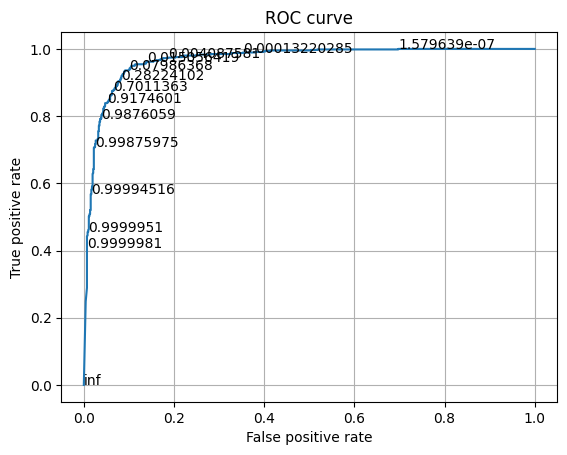

In [ ]:
fp, tp, threshold = roc_curve(labels, predictions[:, 0])
print(len(fp), len(tp), len(threshold))
plt.plot(fp, tp)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
skip = 15

for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], threshold[i])
plt.show()

**PLOT OUT THE LOSS, VAL LOSS, ACC AND VAL ACC**

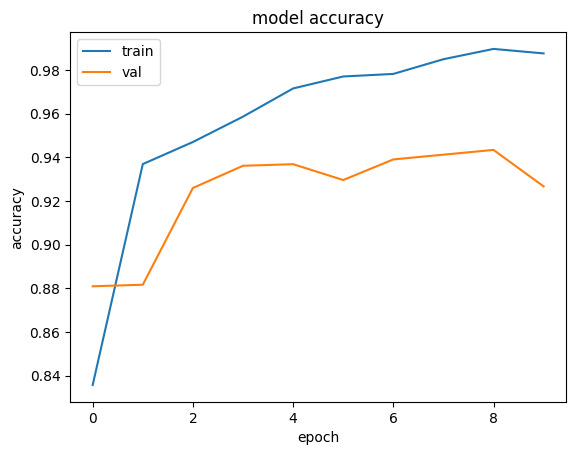

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

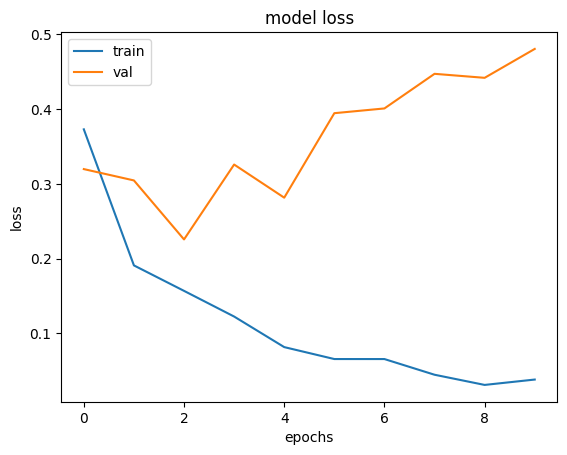

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.show()


**MODEL EVALUATING AND TESTING**

In [ ]:
test_dataset = test_dataset.batch(1)
print(test_dataset)

In [ ]:
custom_model.evaluate(test_dataset)

In [ ]:
test_dataset = test_dataset.unbatch()

In [ ]:
model.predict(test_dataset)

In [ ]:
binary_prediction(model.predict(test_dataset.take(1))[0][0])

In [ ]:
# return P for x ~= 0 and U for x ~= 1
def binary_prediction(x):
    if x < 0.5:
        return str('P')
    else:
        return str('U')

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(36)):
    ax = plt.subplot(6, 6, i+1)
    plt.imshow(image[0])  # eliminate the batch size
    plt.title(f'{binary_prediction(model.predict(image)[0][0])} : {binary_prediction(label.numpy()[0])}')
    plt.axis('off')

**LOADING AND SAVING THE MODEL**

In [ ]:
model.export("Saved_model")
model.save("Saved_model.keras")

In [ ]:
model.save_weights("model_weights.weights.h5")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/Saved_model /content/drive/MyDrive/

In [ ]:
!cp -r /content/Saved_model.keras /content/drive/MyDrive/

In [ ]:
!cp -r /content/model_weights.weights.h5 /content/drive/MyDrive/